In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from tensorflow.keras import layers, models, regularizers

# Path to the downloaded dataset
dataset_dir = "archive"


# Function to load images and annotations
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    annotations_dir = os.path.join(dataset_dir, "annotations")
    
    images = []
    labels = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                label = 'with_mask' if label == 'with_mask' else 'without_mask'  # Assuming binary classification
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                image_path = os.path.join(images_dir, root.find('filename').text)
                image = cv2.imread(image_path)
                image = image[ymin:ymax, xmin:xmax]  # Crop the image based on bounding box
                image = cv2.resize(image, (224, 224))  # Resize the image to a standard size
                images.append(image)
                labels.append(label)
    if not images or not labels:
        print("Error: No data loaded from the dataset.")
        return None, None
    
    return np.array(images), np.array(labels)
             

# Load the dataset
X, y = load_dataset(dataset_dir)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split dataset into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
/Users/divya/anaconda3/envs/NLR/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 494ms/step - accuracy: 0.8017 - loss: 47.8781 - val_accuracy: 0.7954 - val_loss: 1.3567
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 488ms/step - accuracy: 0.9163 - loss: 0.3666 - val_accuracy: 0.9198 - val_loss: 0.2752
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 507ms/step - accuracy: 0.9047 - loss: 0.3345 - val_accuracy: 0.6776 - val_loss: 0.6418
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 488ms/step - accuracy: 0.8522 - loss: 0.3505 - val_accuracy: 0.9394 - val_loss: 0.1908
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 512ms/step - accuracy: 0.8426 - loss: 0.3309 - val_accuracy: 0.7856 - val_loss: 0.4605
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 537ms/step - accuracy: 0.8443 - loss: 0.3079 - val_accuracy: 0.9476 - val_loss: 0.1945
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 543ms/step - accuracy: 0.8585 - loss: 0.2273 - val_accuracy: 0.9427 - val_loss: 0.1992
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 500ms/step - accuracy: 0.8602 - loss: 0.2874 - val_acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


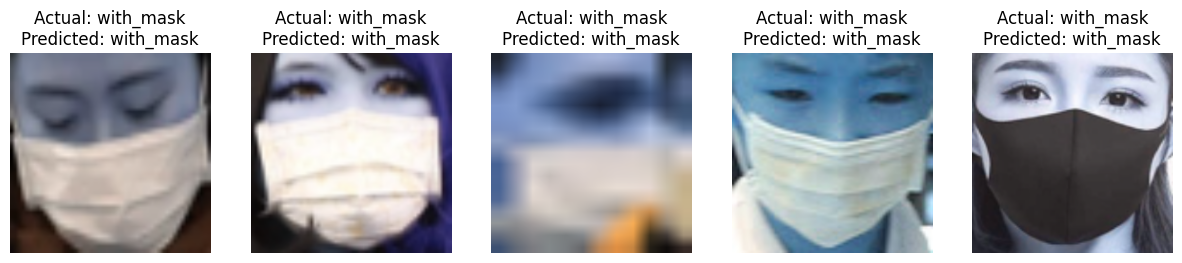

In [7]:
# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Decode labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred.flatten())

# Plot actual vs predicted labels
def plot_actual_vs_predicted(actual, predicted, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(X_test[i])
        axes[i].set_title(f"Actual: {actual[i]}\nPredicted: {predicted[i]}")
        axes[i].axis('off')
    plt.show()

# Test and plot samples
plot_actual_vs_predicted(y_test_decoded, y_pred_decoded)
